## **Libraries**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/cwitkowitz/guitar-transcription-continuous.git
%cd guitar-transcription-continuous
!pip install -r requirements.txt
!pip install -e .
!pip install resampy

fatal: destination path 'guitar-transcription-continuous' already exists and is not an empty directory.
/content/guitar-transcription-continuous
  Cloning https://github.com/cwitkowitz/guitar-transcription-with-inhibition (to revision main) to /tmp/pip-req-build-65zhzie9
  Running command git clone --filter=blob:none --quiet https://github.com/cwitkowitz/guitar-transcription-with-inhibition /tmp/pip-req-build-65zhzie9
  Resolved https://github.com/cwitkowitz/guitar-transcription-with-inhibition to commit e611c1dc9b7340d35c9a697d1658b3b2afb3978a
  Preparing metadata (setup.py) ... done
Obtaining file:///content/guitar-transcription-continuous
  Preparing metadata (setup.py) ... done
  Attempting uninstall: guitar-transcription-continuous
    Found existing installation: guitar-transcription-continuous 0.0.2
    Uninstalling guitar-transcription-continuous-0.0.2:
      Successfully uninstalled guitar-transcription-continuous-0.0.2
  Running setup.py develop for guitar-transcription-conti

In [3]:
!pip uninstall -y numpy
!pip install numpy==1.24.4

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.4 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompati

In [8]:
import os
import torch
import librosa
import numpy as np
import csv

from guitar_transcription_continuous.models.fretnet import FretNet
from amt_tools.features import HCQT
from amt_tools.transcribe import ComboEstimator, TablatureWrapper, StackedOffsetsWrapper, StackedNoteTranscriber
from guitar_transcription_continuous.estimators import StackedPitchListTablatureWrapper
import amt_tools.tools as tools
import guitar_transcription_continuous.utils as utils
import torch.serialization

/usr/local/lib/python3.11/dist-packages/amt_tools/features/stream.py:16: RuntimeWarning: Could not import keyboard, likely because an X connection could not be acquired.
  warnings.warn('Could not import keyboard, likely because an X ' +
/usr/local/lib/python3.11/dist-packages/amt_tools/features/stream.py:22: RuntimeWarning: Could not import sounddevice. Please install PortAudio and try again.
  >>> sudo apt-get install libportaudio2
  warnings.warn('Could not import sounddevice. Please install PortAudio and ' +


In [13]:
from amt_tools.inference import run_offline

In [9]:
model_path = "/content/drive/MyDrive/Automatic Guitar Transcription/nootebooks/feature_extraction/model-2000.pt"
audio_path = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/audio/mono_mic"
jams_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/annotation"
output_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/feature_extraction/fret_string_inference_fretnet"
os.makedirs(output_dir, exist_ok=True)

torch.serialization.add_safe_globals({'FretNet': FretNet})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()
model.change_device(0)

## **Pred Single Audio**

In [10]:
def setup_estimator(model):
    return ComboEstimator([
        TablatureWrapper(profile=model.profile),
        StackedOffsetsWrapper(profile=model.profile),
        StackedNoteTranscriber(profile=model.profile),
        StackedPitchListTablatureWrapper(
            profile=model.profile,
            multi_pitch_key=tools.KEY_TABLATURE,
            multi_pitch_rel_key=utils.KEY_TABLATURE_REL
        )
    ])


In [11]:
def predict_single(audio_path, model, sample_rate=24000):
    audio, _ = librosa.load(audio_path, sr=sample_rate)

    data_proc = HCQT(
        sample_rate=sample_rate,
        hop_length=512,
        fmin=librosa.note_to_hz('E2'),
        harmonics=[0.5, 1, 2, 3, 4, 5],
        n_bins=144,
        bins_per_octave=36
    )

    feats = data_proc.process_audio(audio)
    times = data_proc.get_times(audio)

    # 🔧 Trimlenmiş frame sayısı
    frame_len = feats.shape[-1]
    trimmed_len = frame_len - (frame_len % 9)
    feats = feats[:, :, :trimmed_len]
    times = times[:trimmed_len]

    features = {
        tools.KEY_FEATS: feats,
        tools.KEY_TIMES: times
    }

    estimator = setup_estimator(model)
    predictions = run_offline(features, model, estimator)
    return predictions[tools.KEY_NOTES]


In [14]:
test_file = os.path.join(audio_path, "00_BN1-129-Eb_solo_mic.wav")
notes = predict_single(test_file, model)

for string, (midi_arr, time_arr) in notes.items():
    for midi, (onset, offset) in zip(midi_arr, time_arr):
        print(f"String {string} | Fret {int(midi) - 40} | Onset: {onset:.2f}s | Offset: {offset:.2f}s")


String 2 | Fret 17 | Onset: 1.43s | Offset: 1.69s
String 2 | Fret 17 | Onset: 1.90s | Offset: 2.75s
String 2 | Fret 18 | Onset: 4.20s | Offset: 4.48s
String 2 | Fret 13 | Onset: 19.33s | Offset: 19.58s
String 2 | Fret 13 | Onset: 19.58s | Offset: 20.07s
String 2 | Fret 15 | Onset: 20.54s | Offset: 21.93s
String 3 | Fret 17 | Onset: 2.77s | Offset: 2.79s
String 3 | Fret 22 | Onset: 3.22s | Offset: 3.71s
String 3 | Fret 22 | Onset: 3.71s | Offset: 4.22s
String 3 | Fret 22 | Onset: 5.38s | Offset: 6.53s
String 3 | Fret 15 | Onset: 8.81s | Offset: 9.47s
String 3 | Fret 20 | Onset: 13.03s | Offset: 13.44s
String 3 | Fret 18 | Onset: 13.53s | Offset: 14.21s
String 3 | Fret 18 | Onset: 14.21s | Offset: 14.87s
String 3 | Fret 18 | Onset: 14.89s | Offset: 15.13s
String 3 | Fret 17 | Onset: 15.38s | Offset: 15.62s
String 3 | Fret 18 | Onset: 15.57s | Offset: 15.59s
String 3 | Fret 20 | Onset: 16.49s | Offset: 16.73s
String 3 | Fret 22 | Onset: 16.92s | Offset: 16.98s
String 3 | Fret 20 | Onset: 

In [15]:
import matplotlib.pyplot as plt

def plot_fret_notes(notes):
    fig, ax = plt.subplots(figsize=(16, 6))

    for string, (midi_arr, time_arr) in notes.items():
        for midi, (onset, offset) in zip(midi_arr, time_arr):
            fret = int(midi) - 40  # fret hesaplaması
            ax.hlines(y=string, xmin=onset, xmax=offset, linewidth=4,
                      label=f"Fret {fret}", color=plt.cm.plasma(fret / 30))
            ax.text((onset + offset) / 2, string + 0.1, str(fret),
                    ha='center', va='bottom', fontsize=8)

    ax.set_yticks(sorted(notes.keys()))
    ax.set_yticklabels([f"String {s}" for s in sorted(notes.keys())])
    ax.set_xlabel("Time (s)")
    ax.set_title("🎸 Predicted Notes (String vs Time)")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

<ipython-input-15-33f6b6dc4031>:19: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


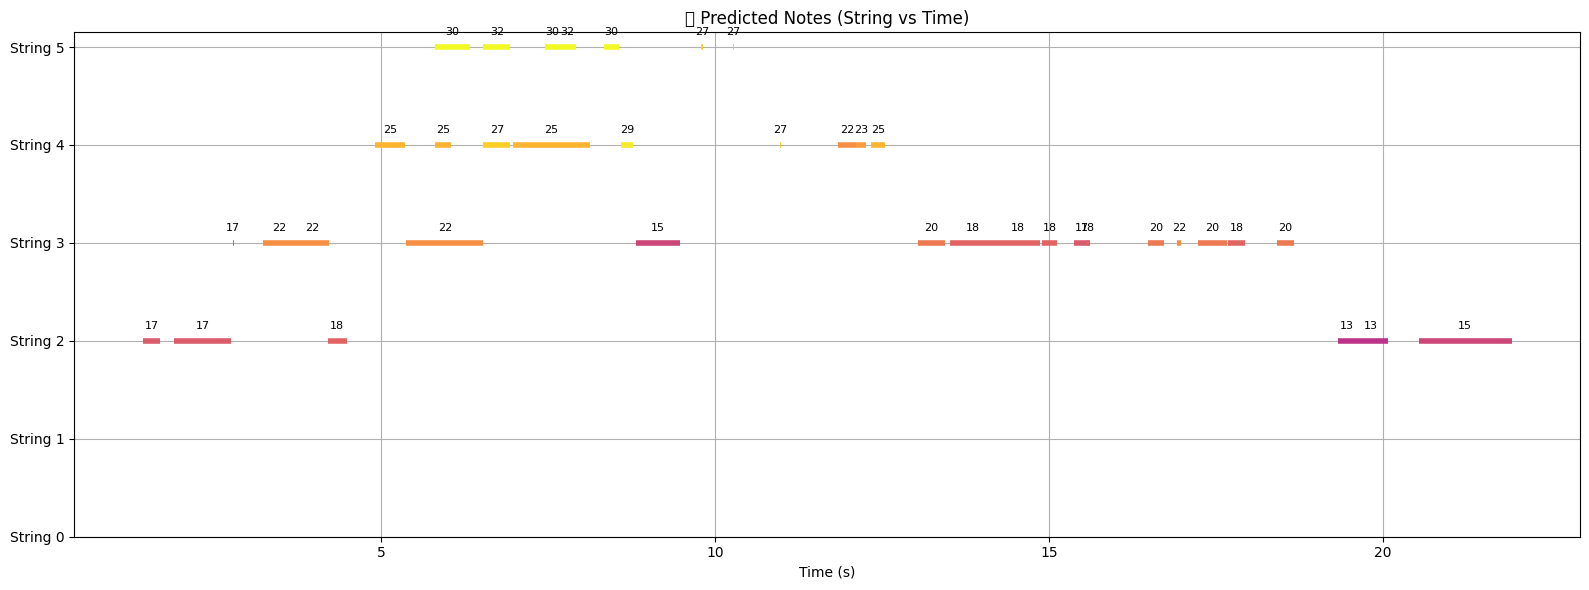

In [16]:
plot_fret_notes(notes)

## **Audio Overlay**

In [23]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_audio_with_predictions(audio_path, notes, sample_rate=22050):
    # 1. Yükle
    audio, sr = librosa.load(audio_path, sr=sample_rate)
    duration = librosa.get_duration(y=audio, sr=sr)

    # 2. Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # 3. Görselleştir
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format="%+2.0f dB")
    plt.title("🎧 Spectrogram + FretNet Predictions")

    # 4. Overlay: Tahmin edilen notaları çubuk olarak çiz
    for string, (midi_arr, time_arr) in notes.items():
        for midi, (onset, offset) in zip(midi_arr, time_arr):
            fret = int(midi) - 40
            plt.hlines(
                y=100 - (string * 10), xmin=onset, xmax=offset,
                colors='white', linewidth=2
            )
            plt.text((onset + offset) / 2, 100 - (string * 10) + 2,
                     str(fret), color='white', fontsize=8, ha='center')

    plt.tight_layout()
    plt.show()


<ipython-input-23-604e354981c1>:31: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


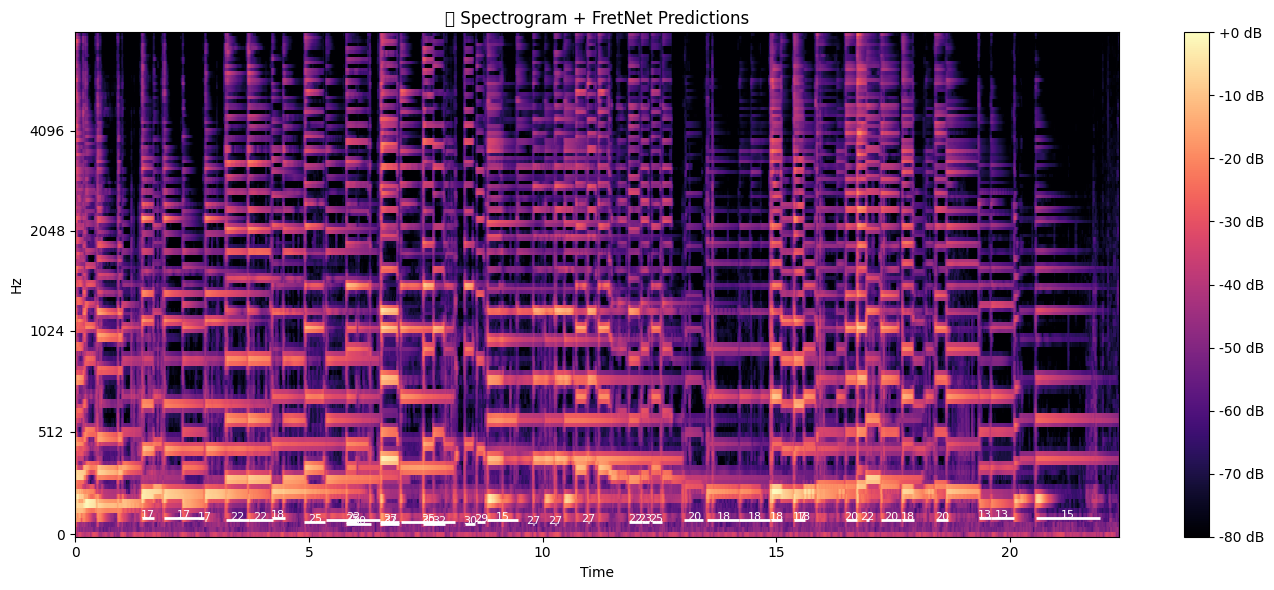

In [24]:
plot_audio_with_predictions(test_file, notes)

## **Pred for All Audios**

In [29]:
import os
import librosa
import jams

mono_mic_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/audio/mono_mic"
output_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/feature_extraction/fret_string_inference_fretnet"
os.makedirs(output_dir, exist_ok=True)

wav_files = [f for f in os.listdir(mono_mic_dir) if f.endswith(".wav")]
print(f"🎸 {len(wav_files)} dosya bulundu.")

def save_notes_as_jams(notes, audio_filename, output_path):
    jam = jams.JAMS()

    # 🔹 Ses süresini al
    audio_path = os.path.join(mono_mic_dir, audio_filename)
    duration = librosa.get_duration(path=audio_path)

    # 🔹 Metadata doldur
    jam.file_metadata.title = audio_filename
    jam.file_metadata.duration = duration

    annotation = jams.Annotation(namespace='note_midi')
    annotation.annotation_metadata = jams.AnnotationMetadata(
        annotator={'name': 'FretNet'},
        version="0.1"
    )

    for string, (midi_arr, time_arr) in notes.items():
        for midi, (onset, offset) in zip(midi_arr, time_arr):
            duration = offset - onset
            annotation.append(time=onset, duration=duration, value=int(midi), confidence=1.0)

    jam.annotations.append(annotation)
    jam.save(output_path)

for file in wav_files:
    input_path = os.path.join(mono_mic_dir, file)
    output_path = os.path.join(output_dir, file.replace(".wav", "_fretnet.jams"))

    try:
        print(f"🔍 İşleniyor: {file}")
        notes = predict_single(input_path, model)
        save_notes_as_jams(notes, file, output_path)
        print(f"✅ Kaydedildi: {output_path}")
    except Exception as e:
        print(f"❌ Hata: {file} -> {e}")


🎸 360 dosya bulundu.
🔍 İşleniyor: 00_BN2-166-Ab_comp_mic.wav
✅ Kaydedildi: /content/drive/MyDrive/Automatic Guitar Transcription/feature_extraction/fret_string_inference_fretnet/00_BN2-166-Ab_comp_mic_fretnet.jams
🔍 İşleniyor: 00_Funk2-119-G_solo_mic.wav
✅ Kaydedildi: /content/drive/MyDrive/Automatic Guitar Transcription/feature_extraction/fret_string_inference_fretnet/00_Funk2-119-G_solo_mic_fretnet.jams
🔍 İşleniyor: 00_Jazz3-137-Eb_solo_mic.wav
✅ Kaydedildi: /content/drive/MyDrive/Automatic Guitar Transcription/feature_extraction/fret_string_inference_fretnet/00_Jazz3-137-Eb_solo_mic_fretnet.jams
🔍 İşleniyor: 00_Jazz2-110-Bb_comp_mic.wav
✅ Kaydedildi: /content/drive/MyDrive/Automatic Guitar Transcription/feature_extraction/fret_string_inference_fretnet/00_Jazz2-110-Bb_comp_mic_fretnet.jams
🔍 İşleniyor: 00_Jazz1-200-B_comp_mic.wav
✅ Kaydedildi: /content/drive/MyDrive/Automatic Guitar Transcription/feature_extraction/fret_string_inference_fretnet/00_Jazz1-200-B_comp_mic_fretnet.jams
🔍 